In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot
import matplotlib.pyplot as plt
from tqdm import tqdm

# Genetic Algorithm

In this Jupyter notebook we will explore a very simple GA. Lets start by loading the breast cancer dataset from the UCI repo (https://archive.ics.uci.edu/ml/datasets/breast+cancer)

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cancer=load_breast_cancer()
df = pd.DataFrame(cancer['data'],columns=cancer['feature_names'])
label=cancer["target"]

# print(type(cancer))
# print(type(cancer['data']))
rows, cols = cancer['data'].shape
print("The dataset has {} rows and {} columns".format(rows,cols))
# print(cancer['data'].shape)
# print(type(label))
# print(label.shape)

The dataset has 569 rows and 30 columns


Lets split this data into training and testing.

In [10]:
#splitting the model into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.30, random_state=101)

# X → features (inputs) → df
# y → labels (targets) → label
# test_size=0.30 → 30% of the data will be testing set, 70% for training
# random_state=101 → fixes the random shuffling so results are reproducible (a seed for the random number generator.)

Let's train a regression model. This is a "machine learing/statistics/..." mathematical model that takes a number of inputs and predicts a set of outputs.

In [11]:
from warnings import filterwarnings
filterwarnings('ignore')

logmodel = LogisticRegression() # build the logistic regression machine
logmodel.fit(X_train,y_train) # the training function
predictions = logmodel.predict(X_test) # run on the test data
print("Accuracy = "+ str(accuracy_score(y_test,predictions))) # what is the accuracy?

Accuracy = 0.9239766081871345


**NOW, what if we use a genetic algorithm for feature selection?** 

That is, maybe all the features are not to our benefit. What if instead we use a subset? Well, how can we find this subset? Why not use a GA? Well, its an example for this class, not arguing here that a GA is the best solution to this particular problem. Trying to keep our example small enough for you to follow!

There are MANY ways we can go about this, for day one, howabout a chromosome is a {USE, NOT USE} per feature. 

First, lets initilize the population.

In [12]:
# size is the number of chromosomes(populations) in the population
# n_feat is the number of features in the dataset.
def initilization_of_population(size, n_feat):
    population = []
    for i in range(size): # do for each chromo
        chromosome = np.ones(n_feat,dtype=bool) # include all features to start
        chromosome[:int(0.3*n_feat)]=False # now, turn off 30% of our features (yes, you could have passed this as an argument!!!)
        np.random.shuffle(chromosome) # randomly shuffle who is on/off
        population.append(chromosome) # add to our population
    return population

Now, lets define our fitness function. 

For each chromosome, we need to train with respect to its feature subset then evaluate it. Yes, that requires a bit of computation.

The function returns a sorted (best to worst) set of scores and chromosomes.

In [13]:
# This function evaluate the chromosomes in the population. 
# The input is the population, which is an array of chromosomes
# The output is a new array of chromosomes sorted according to the scores. (Best chromosome to worest chromosome)
# The original population will not change(这部分python和c不一样，如果在function里面改population，会导致全局变化)

# The score evaluation method is the following:
# Each data entry has a corresponding chromosome. We choose some features(columns) of the data according to its chromosome.
# Use these selected features of samples from training set to get a logistic regression model.
# Use the model to check the accuracy with the testing set. (Only use the selected features, too) Get the score.
# We will know how well these features can train the model.

def fitness_score(population):
    scores = []

    # Iterate through every chomosome. 
    #The chromosome is and array of bools like [T,T,F,F,T]. The X_train.iloc[:,chromosome] select all the lines and only the T columns

    for chromosome in population: 
        # use the features we selected to train a model (iloc = integer-location based indexing in pandas.)
        # In this process we only change the weight parameters in the logistic regression model according to selected features.
        logmodel.fit(X_train.iloc[:,chromosome],y_train) 

        # eval that model (only use the same selected features to predict)
        predictions = logmodel.predict(X_test.iloc[:,chromosome]) 

        # store that score. The score is an evaluation of the model train with selected features(The T columns of chromosome)
        # The accuracy_score(y_true, y_pred) is just   correct predictions/tatol predictions
        scores.append(accuracy_score(y_test,predictions)) 
        
    # We use a new pop to represent the population sorted according to scores without modifying the original population
    scores, pop = np.array(scores), np.array(population.copy()) 

    # returns the indices that would sort an array. 
    # Then make 2 list data structures. One is the descending score, the other is the list of the corresponding chromosomes.
    # ([::-1] reverses the array → largest to smallest)
    inds = np.argsort(scores) 
    scores = list(scores[inds][::-1]) 
    pop = list(pop[inds,:][::-1]) 

    return scores, pop

Now, perform selection, using roulette wheel. In particular, lets say there are two parents to make a child. I will generate twice the number of chromosomes.

In [14]:
# Input:
# scores: list of accuracy scores for each chromosome (sorted descending).
# pop_after_fit: the corresponding population (chromosomes) sorted by accuracy.
# Output:
# population_nextgen: a new population of chromosomes (the "parents" for the next generation).
# The output will be like: [father1(elite),mother1(elite),father2,mother2,father3,mother3....]

def selection(scores,pop_after_fit):
    population_nextgen = []

    # first two entries will be used for elitism (i.e., keep that best solution from generation to next)
    population_nextgen.append(pop_after_fit[0].copy())
    population_nextgen.append(pop_after_fit[0].copy())

    # now, select the other parents. Use the roulette wheel selection.
    max_val = np.sum(scores)
    for i in range(1,len(scores)):  # Assuming the next generation has the same number of chromosomes (x), we need to select (2x-2) chromosomes here. Plue the 2 above. 
        for k in range(2): # 2 parents 
            pick = random.uniform(0, max_val)
            current = 0
            for j in range(len(scores)): # accum
                current += scores[j]
                if current > pick: # our exit criteria based on the probability above
                    break 
            population_nextgen.append(pop_after_fit[j].copy()) 
    # As a result, the chromosomes with higher scores are more likely to be selected.

    return population_nextgen

Crossover here takes two parents and makes a child

The 2 points crossover is like this:

[11111111111]  (parent1)

[22222222222]  (parent2)

[11122222111]  (child)

In [15]:
# The input is the population after the roulette wheel selection.[father1(elite),mother1(elite),father2,mother2,father3,mother3....]
# The 2nd input si the size of the population. (Can be calculated from the size of the list? Don't really need it?)
def crossover(pop_after_sel,sz):
    # The number of the features:
    n_feat = len(pop_after_sel[0])

    # next generation
    population_nextgen = [] 

    # first, elitism (Keep the best chromosome from current generation)
    population_nextgen.append(pop_after_sel[0].copy())
    
    # now, handle the rest
    for i in range(1,sz):
        # make our child  (We set the child the be parent1, then we can modify the parent1)
        child = pop_after_sel[2*i+0].copy()
        # get the second parent
        parent2 = pop_after_sel[2*i+1].copy()
        # two point crossover
        first_cross_point = random.randint(0,n_feat)
        second_cross_point = random.randint(0,n_feat)
        # did we get the same point? have to deal with that
        if( first_cross_point == second_cross_point ):
            first_cross_point = 0
            second_cross_point = n_feat
        # are our swap indices not in order? have to deal with that
        if( first_cross_point > second_cross_point ):
            swaper = first_cross_point
            first_cross_point = second_cross_point
            second_cross_point = swaper
        # swap 
        child[first_cross_point:second_cross_point] = parent2[first_cross_point:second_cross_point]
        population_nextgen.append(child) 
    return population_nextgen

Mutation time!!!

Like all the operations above, there are many ways to implement them (which we talk about in the class). Now, with respect to mutation, here we go through each chromosome and mutate using the probability that the user specified, per feature. 

In [16]:
# mutation是基因突变
# The first input is the population after crossover.
# The 2nd input is the probility of mutation.(hyperparameter)
def mutation(pop_after_cross,mutation_rate,sz):
    population_nextgen = []
    # Elitism
    population_nextgen.append(pop_after_cross[0].copy())
    
    # From the second chromosome, select some genes wrt the probability to flip.
    for i in range(1,sz): # go through each individual
        chromosome = pop_after_cross[i].copy()
        for j in range(len(chromosome)): # go through each feature
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j] # this is the mutation (flip the gene  1->0  0->1)
        population_nextgen.append(chromosome.copy())
    return population_nextgen

Our main function/loop

In [17]:
# 在这个算法里面，chromosome的作用相当于是一个indices，chromosome每一个entry都是一个Boolean。而我们训练的时候用的其实是数据，而这个chromosome的作用是决定在数据所有的feature中，我们选用哪一些feature来训练（如果这个feature对应到chromosome里面的bool是T，那我们就用这个feature参与training，反之则不用）。GA algorithm则是optimize这些选择，或者说，选择哪一些feature我们可以取得更好的训练效果，而训练本身用的还是logistics regression（需要复习这个部分）
# In the selection step, we keep the chromosome(x2) with the best score. But some new generated chormosome might be better after crossover and mutation.

#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

def generations(sz,n_feat,mutation_rate,n_gen,X_train,X_test, y_train, y_test):
    # size = how many chromo's
    # n_feat = how many features
    # mutation rate, [0,1]
    # n_gen == number of generations to run
    # the rest is our training and testing data and labels-=
    best_chromo = []
    best_score = []
    population_nextgen = initilization_of_population(sz,n_feat)
    stats_min = np.zeros(n_gen)
    stats_avg = np.zeros(n_gen)
    stats_max = np.zeros(n_gen)
    for i in tqdm(range(n_gen)):
        # evaluate our chromos
        scores, pop_after_fit = fitness_score(population_nextgen) # The output is an array of chromosomes (best to worst)
        # keep track of best chromo and its score (what we return the end of the day)
        best_chromo.append(pop_after_fit[0].copy())
        best_score.append(scores[0].copy())     # The score is the accuracy we got from the training with the best chromosome   
        # record some stats
        stats_min[i] = np.min(scores)
        stats_max[i] = np.amax(scores)
        stats_avg[i] = np.mean(scores)
        # do our GA
        pop_sel = selection(scores,pop_after_fit) 
    
        pop_after_cross = crossover(pop_sel,sz)
        population_nextgen = mutation(pop_after_cross,mutation_rate,sz)
    return best_chromo,best_score,stats_min,stats_avg,stats_max

Run the algorithm and plot some statistics per generation

  0%|          | 0/100 [00:00<?, ?it/s]

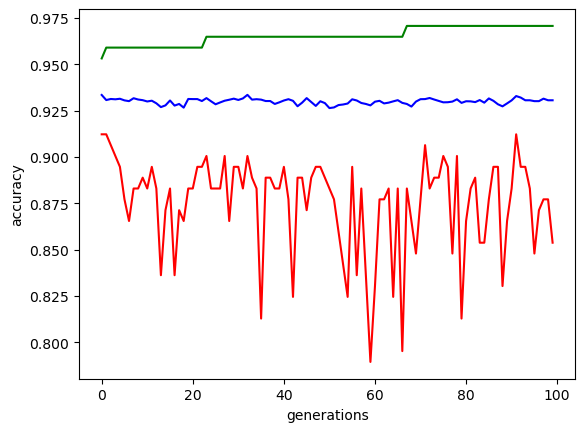

In [18]:
s = 100 # number of individuals
feat = 30 # number of features in our problem
ngen = 100 # number of generations
chromo,score,stats_min,stats_avg,stats_max=generations(sz=s,n_feat=feat,mutation_rate=0.10,n_gen=ngen,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)

# plot the statistics
plt.plot(stats_min,'r')
plt.plot(stats_avg,'b')
plt.plot(stats_max,'g')
plt.ylabel('accuracy')
plt.xlabel('generations')
plt.show()

# Q&A

Things for you to consider

 * We used elitism, was the best score (strictly?) monotonicly increasing? Explain.
 * Change crossover and/or mutation to a different operator
 * Do you want little or a lot of variance in your (min, average, max) statistics (whats a healthy profile)?
 * When should you terminate? 
 * Plug in a different optimization problem from https://en.wikipedia.org/wiki/Test_functions_for_optimization

Got it! Let’s go through each question carefully and explain what’s going on in the context of your Genetic Algorithm (GA). I’ll answer them in simple, clear terms.

---

## **1️⃣ Elitism and monotonicity of the best score**

* **Elitism** means we keep the **best individual** from the previous generation into the next one.
* Because we always keep the best solution, the **best score is guaranteed not to get worse** — it either stays the same or improves.
* **Strict monotonicity?**

  * Not guaranteed!
  * The best score can **stay the same** for multiple generations if no child improves it.
  * Only monotonic in a **non-decreasing sense**, not strictly increasing.

✅ **Answer:**

> The best score is non-decreasing due to elitism, but it may not strictly increase every generation.

---

## **2️⃣ Changing crossover and/or mutation**

* **Current crossover:** two-point crossover.

* **Alternative crossover operators:**

  * **Single-point crossover** → swap genes after a single cut point.
  * **Uniform crossover** → for each gene, randomly pick from parent1 or parent2.

* **Current mutation:** bit-flip with a fixed probability.

* **Alternative mutation operators:**

  * **Swap mutation** → swap two genes in the chromosome.
  * **Inversion mutation** → reverse a segment of genes.
  * **Gaussian mutation** → for real-valued chromosomes, add small random noise.

> Changing these operators affects diversity, convergence speed, and the chance to escape local optima.

---

## **3️⃣ Variance in min, avg, max statistics**

* The `(min, avg, max)` statistics tell you about **population diversity** each generation:

  * **Little variance** → most chromosomes are similar → fast convergence, but risk of local optimum.
  * **A lot of variance** → population is diverse → slower convergence, but higher chance to find global optimum.

✅ **Healthy profile:**

* Min and max should **improve over generations**.
* Average should gradually move toward the min (or max, depending on problem).
* Some variance is healthy; too little → stagnation, too much → inefficient search.

---

## **4️⃣ When to terminate**

Common termination criteria for GA:

1. **Fixed number of generations** → what you currently use (`n_gen`).
2. **Convergence** → stop if the best score hasn’t improved for several generations.
3. **Threshold fitness** → stop if best score reaches a target value.
4. **Resource limits** → time or computational budget.

> In practice, a combination is often used: max generations OR no improvement for X generations.

---

## **5️⃣ Plug in a different optimization problem**

* You can replace your fitness function with any **test function from Wikipedia**: [Test functions for optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization)
* Examples: **Sphere function, Rastrigin, Rosenbrock**

### Example: Sphere function

```python
# For real-valued GA
def fitness_score(population):
    scores = []
    for chromo in population:
        # Sphere function: f(x) = sum(x_i^2)
        score = sum([x**2 for x in chromo])
        scores.append(score)
    # Sort ascending (minimize)
    sorted_idx = np.argsort(scores)
    population_sorted = [population[i] for i in sorted_idx]
    scores_sorted = [scores[i] for i in sorted_idx]
    return scores_sorted, population_sorted
```

* This is just a **drop-in replacement** for your current fitness function.
* The GA will then try to **minimize the function**.

---

✅ **Summary of answers for the questions section:**

| Question                       | Answer                                                                           |
| ------------------------------ | -------------------------------------------------------------------------------- |
| Best score monotonic?          | Non-decreasing, not strictly increasing                                          |
| Change crossover/mutation      | Options: single-point/uniform crossover, swap/inversion/Gaussian mutation        |
| Variance in stats              | Some variance is healthy; too little → stagnation, too much → inefficient search |
| Termination                    | Max generations, convergence (no improvement), or target fitness                 |
| Different optimization problem | Use Sphere, Rastrigin, Rosenbrock, etc.; replace fitness function accordingly    |

---

If you want, I can **write a small example GA code using the Sphere function**, so you can **plug it directly into your notebook and see the results**.

Do you want me to do that?
